In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
import pandas as pd

C:\Users\shubh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shubh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shubh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shubh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# hyperparameters
hidden_size = 256
learning_rate = 0.01

# Constants
GAMMA = 0.99
max_episodes = 500

In [4]:
class A2C(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(A2C, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

In [6]:
def train_A2C(env):
    num_inputs = env.observation_space.shape[0] ########
    num_outputs = env.action_space.n ################
    
    actor_critic = A2C(num_inputs, num_outputs, hidden_size) ###########
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate) ########

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term = 0
    epsilon = 0.0081

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []
        steps = 0
        state = env.reset()
        while True:
            steps += 1
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 
#             print(policy_dist)
#             dist[np.where(dist == np.nan)] = 1e-30
    
#                 print(dist)
            dist = epsilon * np.random.rand(1,9) + dist
#                 print(dist)
            dist = dist/np.sum(dist)
#             print(dist)
            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action] + 1e-30)
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step(action)
#             reward -= 1
            env.render()

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state
#             epsilon = epsilon * 0.9999
            
            if done:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 10 == 0:                    
                    print("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                    print(epsilon)
                break
        
        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval
        
        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
#         log_probs = np.array(log_probs)
#         log_probs[np.where(log_probs == -np.inf)] = -1e10
#         log_probs = log_probs.tolist()
#         print(log_probs)
        log_probs = torch.stack(log_probs)
        
        
        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term
#         print(actor_loss)
        

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

        
    
    # Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()
    return all_rewards

episode: 0, reward: 330.0, total length: 909, average length: 909.0 

0.0081
episode: 10, reward: 250.0, total length: 707, average length: 832.3 

0.0081
episode: 20, reward: 550.0, total length: 941, average length: 840.4 

0.0081
episode: 30, reward: 340.0, total length: 600, average length: 935.8 

0.0081
episode: 40, reward: 410.0, total length: 1245, average length: 855.3 

0.0081
episode: 50, reward: 210.0, total length: 957, average length: 837.9 

0.0081
episode: 60, reward: 430.0, total length: 827, average length: 753.0 

0.0081
episode: 70, reward: 320.0, total length: 1246, average length: 915.0 

0.0081
episode: 80, reward: 320.0, total length: 824, average length: 859.8 

0.0081
episode: 90, reward: 320.0, total length: 1079, average length: 874.2 

0.0081
episode: 100, reward: 480.0, total length: 796, average length: 846.9 

0.0081
episode: 110, reward: 210.0, total length: 640, average length: 794.9 

0.0081
episode: 120, reward: 470.0, total length: 1261, average len

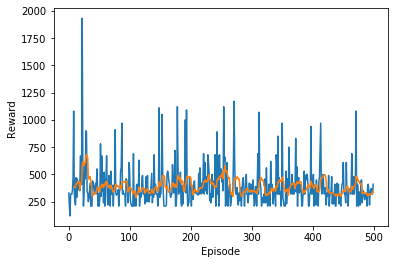

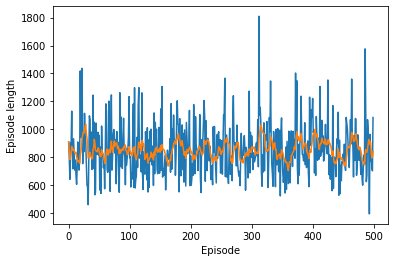

In [7]:
env = gym.make('MsPacman-ram-v0')

rewards = train_A2C(env)
env.close()

In [9]:
 plt.plot(all_rewards)

NameError: name 'all_rewards' is not defined